In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import chain
import pickle
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
# # Read in average monthly consumption dataframe
X = pd.read_csv('AMC_dataframe.csv', index_col=['ProfileID'])
AMC_df = X.copy()
X.reset_index(inplace = True)

# # Extract household IDs
# sorted_households_ids = pd.read_pickle('sorted_households.pkl') # Read pickle file with household ids that pass Error Threshold
# household_ids = list(sorted_households_ids.values())
# householdIDs =  [l.tolist() for l in household_ids]
# householdIDs = list(map(int, chain.from_iterable(householdIDs)))

# # Filter the sorted households ids in AMC dataframe
# AMC_df = X[X['ProfileID'].isin(householdIDs)] 
# AMC_df.set_index(['ProfileID'], inplace=True)


# Load Gauss Fit features
df_50_150 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
df_150_400 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
df_400_600 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
df_600_1200 = pd.read_csv('data/features/FitFeatures/FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# Load Gauss Fit Features for the winter and weekday features
# df_50_150 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
 # df_150_400 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
# df_400_600 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
# df_600_1200 = pd.read_csv('data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
# df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
# df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# Select all filtered households 
# df_50_150.loc[sorted_households_ids['50_150']] 
# df_150_400.loc[sorted_households_ids['150_400']]
# df_400_600.loc[sorted_households_ids['400_600']] 
# df_600_1200.loc[sorted_households_ids['600_1200']] 
# df_1200_2500.loc[sorted_households_ids['1200_2500']] 

# Create the Gauss Fit Features Dataframe
frame = [df_150_400,df_400_600,df_600_1200,df_1200_2500,df_2500_4000]#df_150_400,df_2500_4000
df = pd.DataFrame()
df = df_50_150.append(frame)

#Select rows based on condition 
df.reset_index(inplace=True)

# Filter out all household ids from Gauss Fit Features Dataframe that are not in AMC dataframe 
df = df[df['ProfileID'].isin(AMC_df.index.values)].copy()
df.set_index(['ProfileID'], inplace=True)
df = df.droplevel([0],axis = 1) # Drop level on multi column

# # Create dataframe with the winter weekday gauss fit features
# df_winter_weekdays = df[df['ProfileID'].isin(AMC_df.index.values)].copy()
# df_winter_weekdays.set_index(['ProfileID'], inplace=True)
# df_winter_weekdays = df_winter_weekdays.droplevel([0],axis = 1) # Drop level on multi column

# # Filter out all household ids from AMC dataframe that are not in Gauss Fit Features Dataframe 
AMC_df.reset_index(['ProfileID'], inplace=True)
AMC_df = X[X['ProfileID'].isin(df.index.values)] #df_winter_weekdays.index.values
AMC_df.set_index(['ProfileID'], inplace=True)

# Load Metadata
df1 = pd.read_csv(r"data/survey_data/delskv-1994-2014.csv",  header=[0], index_col = 0)
meta_df = df1[['floor_area', 'wall_material','total_adults', 'total_children','monthly_income','water_access','roof_material','years_electrified']] # Select relevant features
meta_df['total_residents'] = meta_df.loc[:,'total_adults'] + meta_df.loc[:,'total_children'] # Create total_residents feature

<ipython-input-3-a4ab6e25ad77>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['total_residents'] = meta_df.loc[:,'total_adults'] + meta_df.loc[:,'total_children'] # Create total_residents feature


### Filter the Meta dataframe and the AMC dataframe

In [4]:
# Drop all NaN values from dataframe
meta_df = meta_df.dropna()

# Filter out only households with Gauss Fit that completed a survey
households_ids1 = AMC_df.index.to_list()
meta_df_filtered = meta_df.loc[meta_df.index.isin(households_ids1),:]

# # Filter out only households that completed a survey from Gauss Fit
households_ids2 = meta_df_filtered.index.to_list()
AMC_df_filtered = AMC_df.loc[AMC_df.index.isin(households_ids2),:]

In [4]:
# Load the ids with complete winter months
# save list of houeholds with complete winter months
with open("winter_months_ids", "rb") as fp:   # Unpickling
   winter_months_ids = pickle.load(fp)

# Filter out profiles with incomplete winter months
# Filter out only households with Gauss Fit that completed a survey
# households_ids1 = AMC_df.index.to_list()
meta_df_winter = meta_df_filtered.loc[meta_df_filtered.index.isin(winter_months_ids),:]

# # Filter out only households that completed a survey from Gauss Fit
# households_ids2 = meta_df_filtered.index.to_list()
AMC_df_winter = AMC_df_filtered.loc[AMC_df_filtered.index.isin(winter_months_ids),:]

### Create Encoded dataframe

In [5]:
enc = LabelEncoder()

# Encode the non-numeric columns from the Meta Data
enc.fit(meta_df_filtered['roof_material'])
meta_df_filtered.loc[:,'roof_material_ENC'] = enc.transform(meta_df_filtered.loc[:,'roof_material'])

enc.fit(meta_df_filtered['water_access'])
meta_df_filtered.loc[:,'water_access_ENC'] = enc.transform(meta_df_filtered.loc[:,'water_access'])

enc.fit(meta_df_filtered['wall_material'])
meta_df_filtered.loc[:,'wall_material_ENC'] = enc.transform(meta_df_filtered.loc[:,'wall_material'])

meta__df_encoded = meta_df_filtered.loc[:,['floor_area', 'monthly_income','total_residents','roof_material_ENC','water_access_ENC','wall_material_ENC', 'years_electrified']].copy()
encoded_df = pd.merge(meta__df_encoded,AMC_df, left_index = True,right_index=True)

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Create encoded dataframe containing the meat data, gauss fit data and the AMC data

In [6]:
# ids_winters_months = pd.read_pickle(r'winter_months_ids') # Uncomment when using only winter weekdays data

encoded_df2 = pd.merge(encoded_df, df, left_index = True, right_index = True) # df_winter_weekdays

# encoded_df_filtered = encoded_df2.loc[encoded_df2.index.isin(ids_winters_months),:] # Uncomment when using winter weekdays dataframe

In [23]:
# AMC_Fit_df = pd.read_csv('AMC_FIT_kmeans_dataframe.csv')
# AMC_Fit_df.set_index(['ProfileID'], inplace = True)

# # Dropping a level down
# # df.columns = df.columns.droplevel(0)
# encoded_df2 = pd.merge(meta__df_encoded,AMC_Fit_df, left_index = True,right_index=True)

### Remove outliers in Gauss_fit dataframe

In [81]:
# Remove outliers

# Find absolute value of z-score for each observation
z = np.abs(stats.zscore(df2))

# #only keep rows in dataframe with all z-scores less than absolute value of 3 
df2 = df2[(z<3).all(axis=1)]

# Perform Linear Regression

In [7]:
encoded_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2109 entries, 121 to 12029032
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   floor_area         2109 non-null   float64
 1   monthly_income     2109 non-null   float64
 2   total_residents    2109 non-null   int64  
 3   roof_material_ENC  2109 non-null   int32  
 4   water_access_ENC   2109 non-null   int32  
 5   wall_material_ENC  2109 non-null   int32  
 6   years_electrified  2109 non-null   float64
 7   AMC_winter         2109 non-null   float64
 8   AMC_yearly         2109 non-null   float64
 9   sigma1             2109 non-null   float64
 10  sigma2             2109 non-null   float64
 11  mu1                2109 non-null   int64  
 12  A1                 2109 non-null   float64
 13  sigma3             2109 non-null   float64
 14  sigma4             2109 non-null   float64
 15  mu2                2109 non-null   int64  
 16  A2                

### On all points

R2 = -0.2413323367086282
Adjusted r2 = -0.24192148352244347
AIC = 31347.365418406076


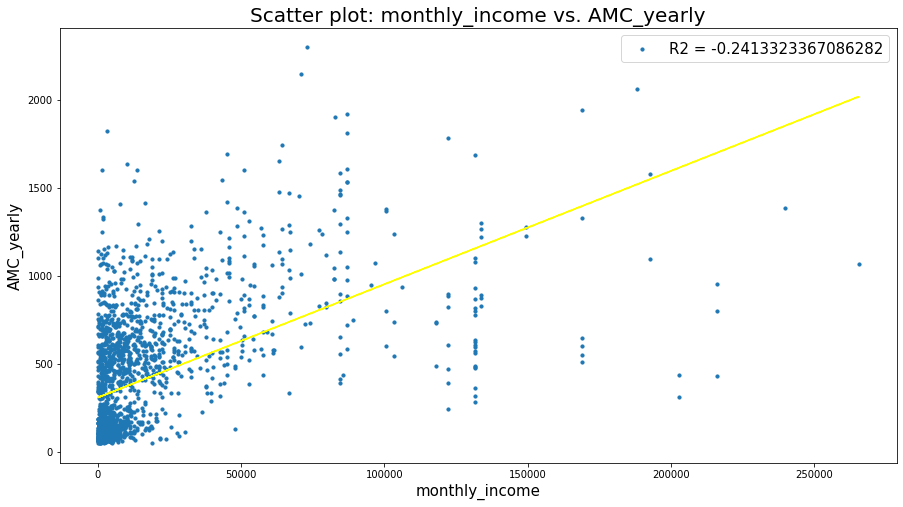

In [17]:
from sklearn.metrics import r2_score
import statsmodels.api as sm


feature1 = 'monthly_income'
feature2 = 'AMC_yearly'

x = encoded_df_filtered[feature1]
y = encoded_df_filtered[feature2]

n = len(x)
p = 1

r2 = r2_score(x, y)
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print(f"R2 = {r2}")
print(f"Adjusted r2 = {Adj_r2}")

x_label = feature1
y_label = feature2

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

fig, ax = plt.subplots(figsize =(15, 8))

#fit regression model
model = sm.OLS(y, x).fit()
AIC = model.aic
print(f'AIC = {AIC}')

plt.scatter(x, y, s = 10,label = "R2 = " + str(r2))
plt.plot(x, mymodel, c = 'yellow')
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + x_label + " vs. " + y_label)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
# ax.set_ylim(0,20)
plt.legend(prop = {'size':15})
# ax.set_yscale(scale)
# ax.set_xscale(scale)
plt.show()

### On median points

In [123]:
# Create binned dataset
df = pd.DataFrame()
df = pd.merge(df2_filtered['Morning'], meta_df_filtered, left_index=True, right_index=True)


bins = np.arange(0,1000,100)

df['bins'] = pd.cut(df.floor_area, bins=bins,  right=False, include_lowest=True)

sigma1_median = df.groupby(['bins'])['sigma1'].median() # Calculate median sigma value for each bin
sigma_1_DF = sigma1_median.to_frame() 
sigma_1_DF['bins'] = np.arange(0,900,100)

In [122]:
encoded_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3973 entries, 121 to 12029036
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   floor_area         3973 non-null   float64
 1   monthly_income     3973 non-null   float64
 2   total_residents    3973 non-null   int64  
 3   roof_material_ENC  3973 non-null   int32  
 4   water_access_ENC   3973 non-null   int32  
 5   wall_material_ENC  3973 non-null   int32  
 6   years_electrified  3973 non-null   float64
 7   sigma1             3973 non-null   float64
 8   sigma2             3973 non-null   float64
 9   mu1                3973 non-null   int64  
 10  A1                 3973 non-null   float64
 11  sigma3             3973 non-null   float64
 12  sigma4             3973 non-null   float64
 13  mu2                3973 non-null   int64  
 14  A2                 3973 non-null   float64
 15  AMC_yearly         3973 non-null   float64
 16  A1_kWh            

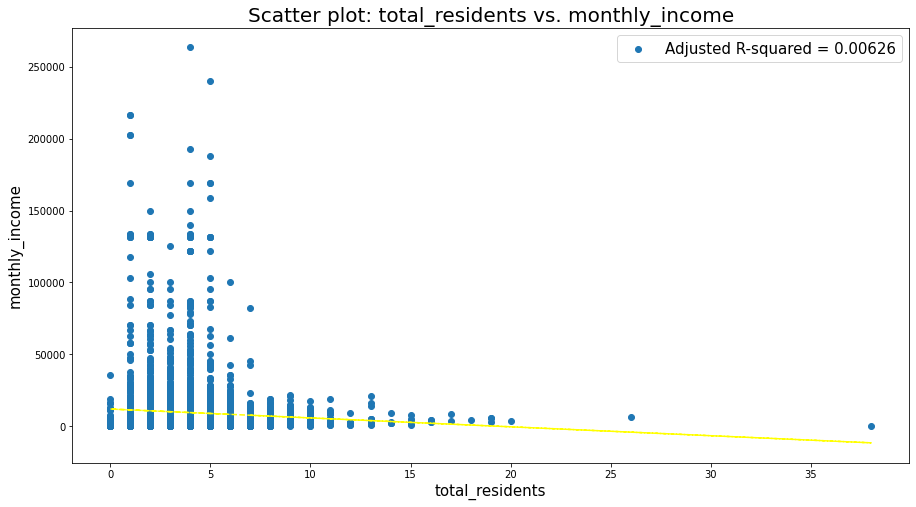

In [133]:
encoded_df2_0 = encoded_df2[encoded_df2['A1_labels'] == 1].copy()

x_feature = 'total_residents'
y_feature =  'monthly_income'
# import statsmodels.api as sm

# fit regression model
model = LinearRegression()
y, X = encoded_df2[y_feature], encoded_df2[x_feature]

X = np.array(X.values.tolist())
y = np.array(y.values.tolist())

# y = y.reshape(-1,1)
X = X.reshape(-1,1)

model.fit(X, y) # Linear Regression model

#display adjusted R-squared
r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

# x = sigma_1_DF['bins']
# y = sigma_1_DF['sigma1']

x_label = x_feature
y_label = y_feature

fig, ax = plt.subplots(figsize =(15, 8))

plt.scatter(X,y, label = "Adjusted R-squared = " + str('{0:.3g}'.format(r2)))
plt.plot(X, model.predict(X), '--', c = 'yellow')
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + x_label + " vs. " + y_label)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
# ax.set_ylim(0,2)
plt.legend(prop = {'size':15})
# ax.set_yscale(scale)
# ax.set_xscale(scale)
plt.show()

fig.savefig("LR_" + x_label + "vs" + y_label + ".png", bbox_inches='tight')

In [55]:
# temp = meta_df_filtered.loc[~(meta_df_filtered['monthly_income'] == 0.0)] # filter out all households with R0 monthly income, Treat as incorrectly filled in questionaire

# temp_df = pd.merge(meta_df_filtered['monthly_income'], df2['Morning']['sigma1'], left_index=True, right_index=True)

# Regression on AMC vs meatdata 10 bins

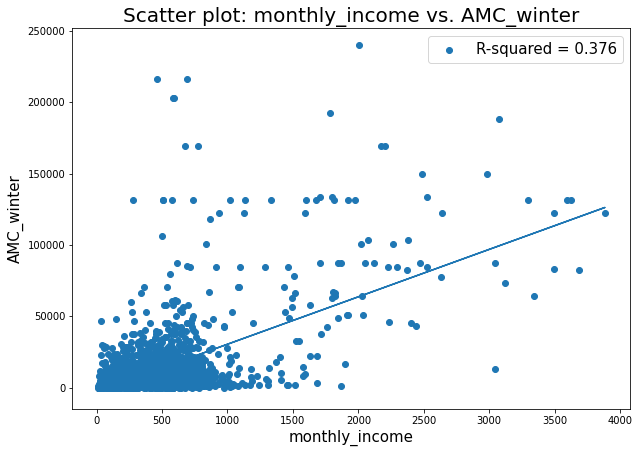

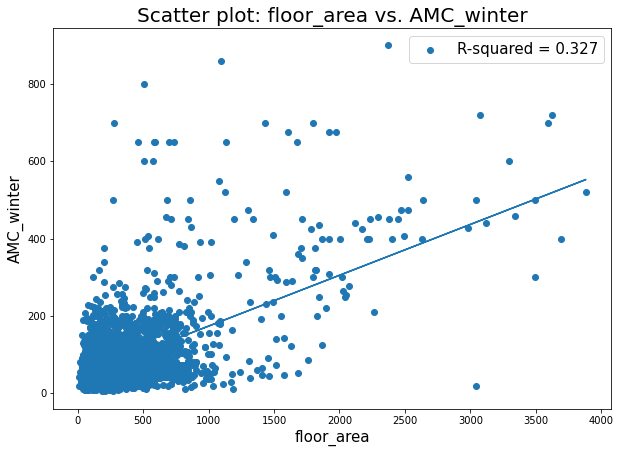

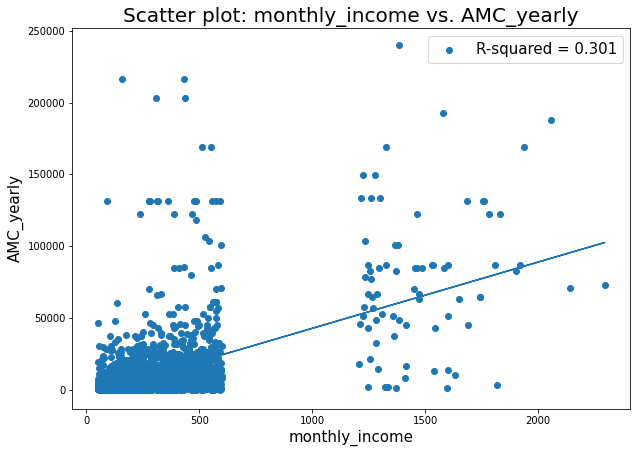

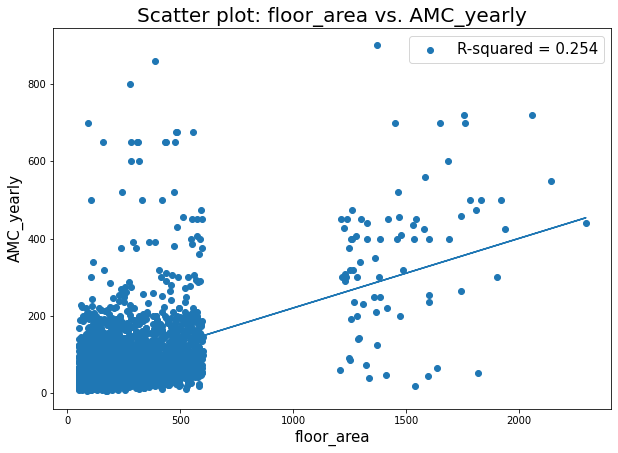

In [51]:
column_string = ['monthly_income', 'floor_area']

for j in AMC_df_filtered:

    for column in column_string:
    
        temp_df = pd.merge(meta_df_winter[column], AMC_df_filtered[j], left_index=True, right_index=True)

        # temp_df = pd.merge(meta_df_filtered['monthly_income'], df2[day][j], left_index=True, right_index=True)

        # Bin the data frame by "a" with 10 bins...
        bins = np.linspace(temp_df[column].min(), temp_df[column].max(), 10)
        groups = temp_df.groupby(np.digitize(temp_df[column], bins))
        
        # fit regression model
        model = LinearRegression()
        y, X = temp_df[column], temp_df[j]

        X = np.array(X.values.tolist())
        y = np.array(y.values.tolist())
        # y = groups.median()[j]
        # X = bins

        X = X.reshape(-1,1)

        model.fit(X, y) # Linear Regression model

        #display adjusted R-squared
        r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

        x_label = temp_df.columns[0]
        y_label = temp_df.columns[1]

        fig, ax = plt.subplots(figsize =(10, 7))

        plt.scatter(X, y, label = "R-squared = " + str('{0:.3g}'.format(r2)))
        plt.plot(X, model.predict(X))
        plt.rc('axes', titlesize=20) 
        plt.rc('axes', labelsize=15)
        plt.title("Scatter plot: " + x_label + " vs. " + y_label)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        # ax.set_ylim(0,2)
        plt.legend(prop = {'size':15})
        # ax.set_yscale(scale)
        # ax.set_xscale(scale)
        plt.show()


        # print(day)

        # Morning
        # # Save the figure
        # fig.savefig("/thesis_project/Figures/regression/" + day + "/" +j +"vs" + column + ".png", bbox_inches='tight')
        fig.savefig("LR_" + x_label + "vs" + y_label + ".png", bbox_inches='tight')

# Linear Regression no-binning

In [48]:
AMC_Fit_df = pd.read_csv('AMC_FIT_kmeans_dataframe.csv')
AMC_Fit_df.set_index(['ProfileID'], inplace=True)

In [86]:
AMC_Fit_df_0 = AMC_Fit_df[AMC_Fit_df['A1_labels'] == 1]

In [55]:
from itertools import combinations

y_feature = ['A2_kWh', 'A1_kWh']
x_features = ['AMC_yearly']

# list_combinations = list()
# for n in range(len(x_features) + 1):
#     list_combinations += list(combinations(x_features, n))

i = 1
for features in y_feature:
    #Setting the value for X and Y
    x = AMC_Fit_df_0[x_features]#
    y = AMC_Fit_df_0[features]

    #Splitting the dataset
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)


    mlr = LinearRegression()  
    mlr.fit(x_train, y_train)

    #Intercept and Coefficient
    print("Intercept: ", mlr.intercept_)
    print("Coefficients:")
    list(zip(x, mlr.coef_))

    #Prediction of test set
    y_pred_mlr= mlr.predict(x_test)
    # y_pred_mlr = y_pred_mlr.reshape(-1)
    #Predicted values
    print("Prediction for test set: {}".format(y_pred_mlr))

    #Actual value and the predicted value
    mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
    mlr_diff.head()

    #Model Evaluation
    from sklearn import metrics
    meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
    meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
    print('R squared: {:.2f}'.format(mlr.score(x,y)*100))
    print('Mean Absolute Error:', meanAbErr)
    print('Mean Square Error:', meanSqErr)
    print('Root Mean Square Error:', rootMeanSqErr)

#     rows = [['y_features:', 'x_features: '],
#             [y_feature,list(features)],
#             ['Intercept', mlr.intercept_],
#             ['R-squared', mlr.score(x,y)*100],
#             ['MAE', meanAbErr],
#             ['MSE', meanSqErr],
#             ['RMSE', rootMeanSqErr]]

#     # from the numpy module
#     np.savetxt('mlr_results_A2_' + str(i)  +'.csv', 
#             rows,
#             delimiter ="; ", 
#             fmt ='% s')
    
#     i = i + 1

Intercept:  0.20946171425227555
Coefficients:
Prediction for test set: [0.37358691 1.19905707 0.37134108 ... 0.83721967 0.34758858 0.37790541]
R squared: 36.71
Mean Absolute Error: 0.240977691273205
Mean Square Error: 0.11911141900344101
Root Mean Square Error: 0.3451252222070143
Intercept:  0.04877645157208971
Coefficients:
Prediction for test set: [0.19265147 0.91627307 0.19068274 ... 0.59908007 0.16986088 0.19643714]
R squared: 27.02
Mean Absolute Error: 0.22052262280497673
Mean Square Error: 0.23238781708461223
Root Mean Square Error: 0.48206619574972503


# Multiple Linear Regression

In [87]:
encoded_df2_0 = encoded_df2[encoded_df2['A1_labels'] == 0].copy()

In [13]:
encoded_df_filtered.columns

Index(['floor_area', 'monthly_income', 'total_residents', 'roof_material_ENC',
       'water_access_ENC', 'wall_material_ENC', 'years_electrified',
       'AMC_winter', 'AMC_yearly', 'sigma1', 'sigma2', 'mu1', 'A1', 'sigma3',
       'sigma4', 'mu2', 'A2'],
      dtype='object')

In [8]:
from itertools import combinations

y_feature = 'AMC_yearly'
x_features = ['sigma1', 'sigma2', 'A1', 'mu1', 'sigma3', 'sigma4', 'mu2', 'A2']

list_combinations = list()
for n in range(len(x_features) + 1):
    list_combinations += list(combinations(x_features, n))

i = 1
for features in list_combinations[1:]:
    #Setting the value for X and Y
    x = encoded_df2_0[list(features)]#
    y = encoded_df2_0[y_feature]

    #Splitting the dataset
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)


    mlr = LinearRegression()  
    mlr.fit(x_train, y_train)

    #Intercept and Coefficient
    print("Intercept: ", mlr.intercept_)
    print("Coefficients:")
    list(zip(x, mlr.coef_))

    #Prediction of test set
    y_pred_mlr= mlr.predict(x_test)
    # y_pred_mlr = y_pred_mlr.reshape(-1)
    #Predicted values
    print("Prediction for test set: {}".format(y_pred_mlr))

    #Actual value and the predicted value
    mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
    mlr_diff.head()

    #Model Evaluation
    from sklearn import metrics
    meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
    meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
    print('R squared: {:.2f}'.format(mlr.score(x,y)*100))
    print('Mean Absolute Error:', meanAbErr)
    print('Mean Square Error:', meanSqErr)
    print('Root Mean Square Error:', rootMeanSqErr)

    rows = [['y_features:', 'x_features: '],
            [y_feature,list(features)],
            ['R-squared', mlr.score(x,y)*100],
            ['MAE', meanAbErr],
            ['MSE', meanSqErr],
            ['RMSE', rootMeanSqErr]]

    # from the numpy module
    np.savetxt('mlr_results_AMC_yearly(fit1)_' + str(i)  +'.csv', 
            rows,
            delimiter ="; ", 
            fmt ='% s')
    
    i = i + 1

# # Save results
# import csv
# # x_feature = '\',\''.join(x_features)
# with open('mlr_results' + y_feature +'.csv', 'wb') as csvfile:
#     filewriter = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     filewriter.writerow([y_feature, 'x_features:', ])
#     filewriter.writerow(['Intercept', mlr.intercept_])
#     filewriter.writerow(['R-squared', mlr.score(x,y)*100])
#     filewriter.writerow(['MAE', meanAbErr])
#     filewriter.writerow(['MSE', meanSqErr])
#     filewriter.writerow(['RMSE', rootMeanSqErr])

In [18]:
encoded_df_filtered.columns


Index(['floor_area', 'monthly_income', 'total_residents', 'roof_material_ENC',
       'water_access_ENC', 'wall_material_ENC', 'years_electrified',
       'AMC_winter', 'AMC_yearly', 'sigma1', 'sigma2', 'mu1', 'A1', 'sigma3',
       'sigma4', 'mu2', 'A2'],
      dtype='object')

In [57]:
encoded_df2

,ProfileID,floor_area,monthly_income,total_residents,roof_material_ENC,water_access_ENC,wall_material_ENC,years_electrified,AMC_winter,AMC_yearly,sigma1,sigma2,mu1,A1,sigma3,sigma4,mu2,A2
0,121,50.0,23396.23,7,0,3,2,10.0,157.842976,368.275604,2.400000,2.400000,10,1.642114,3.870968,2.666667,18,2.836229
1,122,50.0,6981.13,4,0,3,2,10.0,361.899844,651.857427,2.089552,6.400000,8,4.877754,2.424242,1.562500,19,6.353343
2,123,50.0,12452.83,8,0,3,2,10.0,226.768590,571.824360,3.333333,2.352941,10,2.947057,2.051282,3.414634,17,5.374600
3,124,50.0,15094.34,10,0,3,2,10.0,242.603886,658.141400,2.727273,4.615385,10,5.421163,2.307692,2.727273,18,6.122340
4,125,50.0,7924.53,7,0,3,2,10.0,327.069246,803.409776,0.720721,2.307692,6,4.682133,3.636364,1.538462,20,6.177590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4564,12029006,61.0,9659.09,4,4,2,6,2.0,279.309869,240.705221,0.377358,2.727273,4,3.134615,1.212121,2.857143,18,2.457051
4565,12029010,59.0,227.27,1,4,2,6,30.0,396.253795,415.556173,3.750000,2.500000,9,1.574381,2.222222,1.923077,19,3.172974
4566,12029019,132.0,1022.73,2,4,3,6,30.0,412.007433,448.671829,0.560748,2.857143,6,2.427948,2.068966,2.500000,19,3.604192
4567,12029032,126.0,920.45,4,7,3,6,26.0,1869.001213,1370.898039,2.173913,2.285714,8,5.347899,2.580645,2.352941,18,6.608913


# Building a model using Aike information Criterion

In [62]:
encoded_df2.set_index(['ProfileID'],inplace = True)

In [68]:

import pandas as pd
from patsy import dmatrices
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import matplotlib.pyplot as plt

#Read the data set into a pandas DataFrame
# df = pd.read_csv('boston_daily_temps_1978_2019.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

#resample at a month level
# df_resampled = df.resample('M').mean()

# #Plot the data set
# fig = plt.figure()
# fig.suptitle('Monthly Average temperatures in Boston, MA from 1978 to 2019')
# actual, = plt.plot(encoded_df_filtered['monthly_income'], encoded_df_filtered['A1'], 'go-', label='Monthly Average Temperature')
# plt.xlabel('Date')
# plt.ylabel('Temperature')
# plt.legend(handles=[actual])
# plt.show()

# print(df_resampled.head())

#Take a copy
df_lagged = encoded_df2.copy()

# #Add time lagged columns to the data set
# for i in range(1, 13, 1):
# 	df_lagged['TAVG_LAG_' + str(i)] = df_lagged['TAVG'].shift(i)

# print(df_lagged.head(13))

# #Drop the NaN rows
# for i in range(0, 12, 1):
# 	df_lagged = df_lagged.drop(df_lagged.index[0])

# print(df_lagged.head())

#Carve out the test and the training data sets
# split_index = round(len(df_lagged)*0.8)
# split_date = df_lagged.index[split_index]
# df_train = df_lagged.loc[df_lagged.index <= split_date].copy()
# df_test = df_lagged.loc[df_lagged.index > split_date].copy()

df_train = df_lagged.sample(frac=0.8, random_state=10)
df_test = df_lagged.drop(df_train.index)

# # split the dataset
# X = encoded_df_filtered['monthly_income']
# y = encoded_df_filtered['A1']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

#Generate and store away, all possible combinations of the list [1,2,3,4,5,6,7,8,9,10,11,12]
lag_combinations = OrderedDict()
l =['floor_area','monthly_income', 'total_residents', 'roof_material_ENC','water_access_ENC', 'wall_material_ENC', 'years_electrified', 'AMC_yearly']

for i in range(1, 16, 1):
	for combination in itertools.combinations(l, i):
		lag_combinations[combination] = 0.0

# print('Number of combinations to be tested: ' + str(len(lag_combinations)))

expr_prefix = 'A2 ~ '

min_aic = sys.float_info.max
best_expr = ''
best_olsr_model_results = None

#Iterate over each combination
for combination in lag_combinations:
	expr = expr_prefix
	i = 1
	#Setup the model expression using patsy syntax
	for lag_num in combination:
		if i < len(combination):
			expr = expr  + str(lag_num) + ' + '
		else:
			expr = expr  + str(lag_num)

		i += 1

	print('Building model for expr: ' + expr)

	#Carve out the X,y vectors using patsy. We will use X_test, y_test later for testing the model.
	y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

	#Build and train the OLSR model on the training data set
	olsr_results = smf.ols(expr, df_train).fit()

	#Store it's AIC value
	lag_combinations[combination] = olsr_results.aic

	#Keep track of the best model (the one with the lowest AIC score) seen so far
	if olsr_results.aic < min_aic:
		min_aic = olsr_results.aic
		best_expr = expr
		best_olsr_model_results = olsr_results

	print('AIC='+str(lag_combinations[combination]))

#Print out the model expression, AIC score and model summary of the best model
print('Best expr=' + best_expr)
print('min AIC=' + str(min_aic))
print(best_olsr_model_results.summary())

#Generate predictions for TAVG on the test data set
olsr_predictions = best_olsr_model_results.get_prediction(X_test)

olsr_predictions_summary_frame = olsr_predictions.summary_frame()
print(olsr_predictions_summary_frame.head(10))

# actual_temps = y_test['sigma4']
# predicted_temps = olsr_predictions_summary_frame['mean']

# #Plot the actual versus predicted values of TAVG on the test data set
# fig, ax = plt.subplots(figsize = (15,8))
# fig.suptitle('Predicted versus actual monthly income')
# predicted, = plt.plot(X_test.AMC_yearly, predicted_temps, 'go-', label='Predicted Amplitude')
# actual, = plt.plot(X_test.AMC_yearly, actual_temps, 'ro-', label='Actual Amplitude')
# plt.legend(handles=[predicted, actual])
# ax.set_xscale('log')
# ax.set_yscale('log')
# fig.set_figwidth(40)
# fig.set_figheight(20)
# plt.show()

Building model for expr: A2 ~ floor_area
AIC=17650.878726805153
Building model for expr: A2 ~ monthly_income
AIC=17749.775830693496
Building model for expr: A2 ~ total_residents
AIC=18747.503842034683
Building model for expr: A2 ~ roof_material_ENC
AIC=18614.240577904966
Building model for expr: A2 ~ water_access_ENC
AIC=18353.42131693406
Building model for expr: A2 ~ wall_material_ENC
AIC=18749.557248262274
Building model for expr: A2 ~ years_electrified
AIC=18732.651534873818
Building model for expr: A2 ~ AMC_yearly
AIC=15379.687470107443
Building model for expr: A2 ~ floor_area + monthly_income
AIC=17526.549702166827
Building model for expr: A2 ~ floor_area + total_residents
AIC=17617.430836769778
Building model for expr: A2 ~ floor_area + roof_material_ENC
AIC=17643.272393331663
Building model for expr: A2 ~ floor_area + water_access_ENC
AIC=17427.080735880627
Building model for expr: A2 ~ floor_area + wall_material_ENC
AIC=17652.279635749434
Building model for expr: A2 ~ floor_are

In [39]:
OLSR_sigma1_df2 = best_olsr_model_results.summary()

In [40]:
print(OLSR_sigma1_df)
print(OLSR_sigma2_df)
print(OLSR_mu1_df)
print(OLSR_A1_df)
print(OLSR_sigma3_df)
print(OLSR_sigma4_df)
print(OLSR_mu2_df)
print(OLSR_A2_df)

                            OLS Regression Results                            
Dep. Variable:                 sigma1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8739
Date:                Tue, 08 Feb 2022   Prob (F-statistic):              0.350
Time:                        16:28:35   Log-Likelihood:            -1.1940e+05
No. Observations:                3655   AIC:                         2.388e+05
Df Residuals:                    3653   BIC:                         2.388e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     1.3e+12   9.57e+11      1.359      0.1

### Store results as pickle file

In [53]:
# y_features = ['A1', 'sigma1', 'sigma2', 'mu1', 'A2', 'sigma3', 'sigma4', 'mu2']

# for feature in y_features:
#     filename = 'OLSR_' + feature

# filename = 'OLSR_results'

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# # Open the file
# with open(filename + 'report.pkl','wb') as outp:
#     # Pass the file handle in as a lambda function to make it callable
#     pickler = pickle.Pickler(outp, -1)
#     pickler.dump(OLSR_A1_df)

tech_companies = [
    OLSR_A1_df, OLSR_sigma1_df,OLSR_sigma2_df,OLSR_mu1_df,OLSR_A2_df,OLSR_sigma3_df,OLSR_sigma4_df,OLSR_mu2_df
]
save_object(tech_companies, 'OSLR_results(ENTIRE).pkl')

## Read results as pickle file

In [54]:
with open('OSLR_results(ENTIRE).pkl', 'rb') as inp:
    OSLR_results = pickle.load(inp)

In [55]:
print(OSLR_results)

[<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                     A1   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     967.2
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:27:17   Log-Likelihood:                -7001.5
No. Observations:                3655   AIC:                         1.402e+04
Df Residuals:                    3647   BIC:                         1.407e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

## PCA on sigma data

In [280]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

x = df2_filtered['Morning'][['sigma1','sigma2']]

principalComponents = pca.fit_transform(x)

e_dataframe=pd.DataFrame(principalComponents,columns = ['pca1']) 
temp_df2 = temp_df.reset_index()
temp_df2  = pd.merge(temp_df2,e_dataframe, right_index=True, left_index=True)